<img src="https://upload.wikimedia.org/wikipedia/commons/9/96/Pytorch_logo.png"
     width="35%"/>

# PyTorch and Optuna

In this example, you'll see how to use Dask and Optuna to optimize a PyTorch Generative Adversarial Network (GAN). This example was partially adapted from this [PyTorch DCGAN Tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).

You can {download}`download this jupyter notebook <gpu-pytorch-optuna.ipynb>` to follow along.

## Start a GPU-enabled cluster

First we need to define a Coiled software environment. Usually, Coiled does this for us automatically by scraping our local environment (see {ref}`package-sync`), but in this case our local laptop doesn't have a GPU or GPU-specific libraries, so we'll need to create a remote software environment explicitly.

In [ ]:
import coiled

coiled.create_software_environment(
    name="pytorch",
    conda={
        "channels": ["pytorch", "nvidia", "conda-forge", "defaults"],
        "dependencies": [
            "python=3.11",
            "dask=2023.5.1",
            "pytorch",
            "optuna",
            "torchvision",
            "cudatoolkit",
            "pynvml"
        ],
    },
    # sets CUDA version for conda to ensure GPU versions of packages are installed
    gpu_enabled=True,
)

Then you can create a cluster with GPU-enabled machines by using the `worker_gpu` argument:

In [ ]:
cluster = coiled.Cluster(
    software="pytorch",
    n_workers=20,
    worker_gpu=1,
    # launch one task per worker to avoid oversaturating the GPU
    worker_options={"nthreads": 1},
)

client = cluster.get_client()

## Defining our PyTorch Model

First, let's import the libraries we need and define the inputs.

In [3]:
import os

import optuna
from optuna.integration.dask import DaskStorage
from optuna.trial import TrialState

import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
from IPython.display import HTML
from distributed import wait

cuda_check = client.submit(torch.cuda.is_available)
print(f"Cuda is available: {cuda_check.result()}")

# Root directory for dataset
dataroot = "data/celeba"

# Number of workers for dataloader
workers = 0  # IMPORTANT w/ optuna; it launches a daemonic process, so PyTorch can't itself use it then.

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

Cuda is available: True


Next we'll load the data. In this example we generate fake data in-memory for demonstration purposes. This dataset can be replaced with your intended dataset.  We do this here to focus more on computation than actual convergence.

In [4]:
# We create a fake image dataset. This ought to be replaced by
# your actual dataset or PyTorch's example datasets.
class FakeImageDataset(torch.utils.data.Dataset):
    def __init__(self, count=1_000):
        self.labels = np.random.randint(0, 5, size=count)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        torch.random.seed = label
        img = torch.rand(3, image_size, image_size)
        return img, label

Generate model weights:

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Define the generator:

In [6]:
class Generator(nn.Module):
    def __init__(self, ngpu, activation=None):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            activation or nn.Sigmoid()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

    @classmethod
    def from_trial(cls, trial):
        activations = [nn.Sigmoid]
        idx = trial.suggest_categorical("generator_activation", list(range(len(activations))))
        activation = activations[idx]()
        return cls(ngpu, activation)

Define the discriminator:

In [7]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, leaky_relu_slope=0.2, activation=None):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(leaky_relu_slope, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(leaky_relu_slope, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(leaky_relu_slope, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(leaky_relu_slope, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            activation or nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
    @classmethod
    def from_trial(cls, trial):
        activations = [nn.Sigmoid]
        idx = trial.suggest_categorical("descriminator_activation", list(range(len(activations))))
        activation = activations[idx]()
        
        slopes = np.arange(0.1, 0.4, 0.1)
        idx = trial.suggest_categorical("descriminator_leaky_relu_slope", list(range(len(slopes))))
        leaky_relu_slope = slopes[idx]
        return cls(ngpu, leaky_relu_slope, activation)

Define loss functions, optimizers, and model training.

In [8]:
def objective(trial):
    dataset = FakeImageDataset()

    # Create the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=workers)
    
    # Decide which device we want to run on
    device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


    ############################
    ### Create the generator ###
    netG = Generator.from_trial(trial).to(device)

    # Handle multi-GPU if desired
    if (device.type == 'cuda') and (ngpu > 1):
        netG = nn.DataParallel(netG, list(range(ngpu)))

    # Apply the ``weights_init`` function to randomly initialize all weights
    #  to ``mean=0``, ``stdev=0.02``.
    netG.apply(weights_init)

    ################################
    ### Create the Discriminator ###
    netD = Discriminator.from_trial(trial).to(device)

    # Handle multi-GPU if desired
    if (device.type == 'cuda') and (ngpu > 1):
        netD = nn.DataParallel(netD, list(range(ngpu)))

    # Apply the ``weights_init`` function to randomly initialize all weights
    # like this: ``to mean=0, stdev=0.2``.
    netD.apply(weights_init)

    ############################################
    ### Remaining crierion, optimizers, etc. ###
    # Initialize the ``BCELoss`` function
    criterion = nn.BCELoss()

    # Create batch of latent vectors that we will use to visualize
    #  the progression of the generator
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)

    # Establish convention for real and fake labels during training
    real_label = 1.
    fake_label = 0.
    
    # Learning rate for optimizers
    lr = 0.00001

    # Setup Adam optimizers for both G and D
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

    #####################
    ### Training Loop ###

    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1

        # Report to Optuna
        trial.report(errD.item(), epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return errD.item()

## Hyperparameter Optimization

In [ ]:
# Set to your heart's desire, patience and cluster size. :)
n_trials = 500

study = optuna.create_study(direction='minimize', storage=DaskStorage(client=client))
jobs = [
    client.submit(study.optimize, objective, n_trials=1, pure=False)
    for _ in range(n_trials)
]

## Analyze the results

In [10]:
_ = wait(jobs)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  500
  Number of pruned trials:  455
  Number of complete trials:  45
Best trial:
  Value:  0.04901490360498428
  Params: 
    generator_activation: 0
    descriminator_activation: 0
    descriminator_leaky_relu_slope: 1


/var/folders/hf/2s7qjx7j5ndc5220_qxv8y800000gn/T/ipykernel_96630/1242152342.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

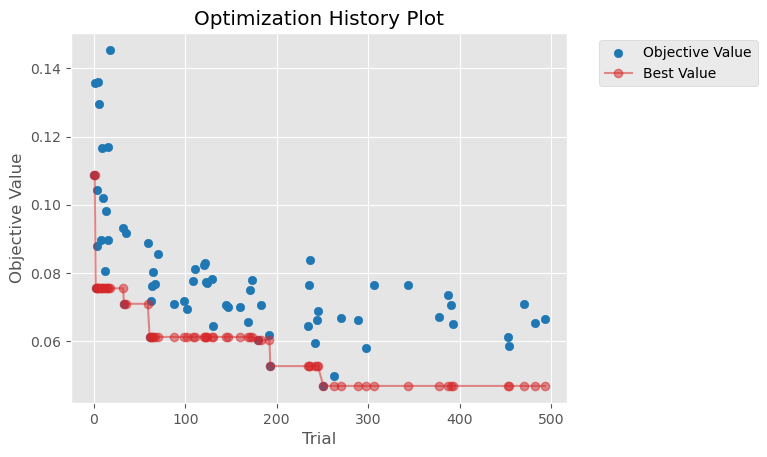

In [6]:
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances

plot_optimization_history(study)

In [14]:
client.shutdown()